In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from keras.models import Model
from keras.applications import VGG19
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from recsys.models import BPR, VBPR
from recsys.metrics import auc_score
from recsys.utils import create_matrix
from recsys.model_selection import create_train_test

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,joblib,keras,recsys

Using TensorFlow backend.


Ethen 2017-04-01 08:05:13 

CPython 3.5.2
IPython 5.1.0

numpy 1.12.1
pandas 0.19.2
matplotlib 2.0.0
joblib 0.10.3
keras 2.0.1
recsys 0.0.1


In [2]:
data = pd.read_csv('model_likes.csv', quotechar = '\\', encoding = 'latin1')
data['interactions'] = 1
print(data.shape)
data.head()

(572751, 4)


,modelname,mid,uid,interactions
0,Firewatch Fan Art,8609caf1cd8c452eb7b6d4ca4228fcd0,c3d22af246056d258c3493582fbf378f,1
1,Firewatch Fan Art,8609caf1cd8c452eb7b6d4ca4228fcd0,6e795101ca8f455070b908a193500410,1
2,Firewatch Fan Art,8609caf1cd8c452eb7b6d4ca4228fcd0,21f84161b0a59f1f05d298c523002fcd,1
3,Firewatch Fan Art,8609caf1cd8c452eb7b6d4ca4228fcd0,21f75b7330fb937f8d905e54f903c1b4,1
4,Firewatch Fan Art,8609caf1cd8c452eb7b6d4ca4228fcd0,be8276038689010a47e0c512b5247d13,1


In [3]:
item_col = 'mid'
user_col = 'uid'
rating_col = 'interactions'
user_threshold = 5
item_threshold = 5
X, data, removed_users, removed_items = create_matrix(data, user_col, item_col, rating_col,
                                                      user_threshold, item_threshold)
X

<11889x19836 sparse matrix of type '<class 'numpy.int32'>'
	with 459958 stored elements in Compressed Sparse Row format>

In [4]:
X_train, X_test = create_train_test(X, test_size = 0.2, seed = 1234)
X_train

<11889x19836 sparse matrix of type '<class 'numpy.int32'>'
	with 362608 stored elements in Compressed Sparse Row format>

In [5]:
bpr_params = {
    'n_factors': 30,
    'learning_rate': 0.05,
    'n_iters': 10,
    'reg': 0.01,
    'n_batch_size': 2048
}

bpr = BPR(**bpr_params)
bpr.fit(X_train)

BPR: 100%|██████████| 10/10 [02:51<00:00, 16.61s/it]


BPR(learning_rate=0.05, n_batch_size=2048, n_factors=30, n_iters=10, reg=0.01,
  seed=1234, verbose=True)

0.95796979738
0.825627608763


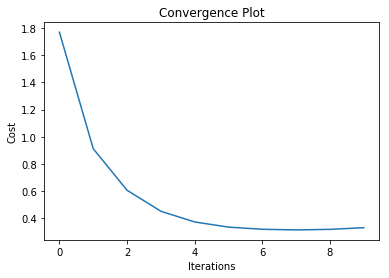

In [6]:
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 10

print(auc_score(bpr, X_train))
print(auc_score(bpr, X_test))
plt.plot(bpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## VBPR

In [7]:
def preprocess_img(img_path, target_size):
    """"""
    img = load_img(img_path, target_size = target_size)
    x = img_to_array(img)
    return x

def preprocess_all_img(categories, img_dir, verbose = True, n_jobs = -1, pre_dispatch = '2*n_jobs'):        
    current_path = os.getcwd()
    os.chdir(img_dir)
    
    # TODO : fix target size since it's relative to the CNN architecture
    target_size = 224, 224
    
    parallel = Parallel(n_jobs = n_jobs, verbose = verbose, pre_dispatch = pre_dispatch)
    x = parallel(delayed(preprocess_img)(img_names + '.jpg', target_size) for img_names in categories)
    os.chdir(current_path)
    
    X_img = np.asarray(x)
    X_img = preprocess_input(X_img)
    return X_img

In [ ]:
# preprocess_input from imagenet_utils is for ResNet only, not for Inception and Xception net.
img_features_path = 'img_features.pkl'
img_dir = 'thumbnails'
categories = data[item_col].cat.categories

if not os.path.exists(img_features_path):
    X_img = preprocess_all_img(categories, img_dir)
    print(X_img.shape)
    
    # getting the image feature takes a while (6000 seconds?)
    base_model = VGG19(weights = 'imagenet')
    model = Model(inputs = base_model.inputs, outputs = base_model.get_layer('fc2').output)
    img_features = model.predict(X_img, verbose = 1)
    joblib.dump(img_features, img_features_path)

# img features is a sparse matrix ????
img_features = joblib.load(img_features_path)
img_features.shape

(19836, 4096)

In [ ]:
vbpr_params = {
    'learning_rate': 0.005,
    'reg': 0.01,
    'reg_img': 0.01,
    'n_iters': 20,
    'n_factors': 30,
    'n_batch_size': 4096,
    'n_img_factors': 20,
    'img_features': img_features
}

vbpr = VBPR(**vbpr_params)
vbpr.fit(X_train)

VBPR:   0%|          | 0/20 [00:00<?, ?it/s]

0.603128319976
0.553017261592


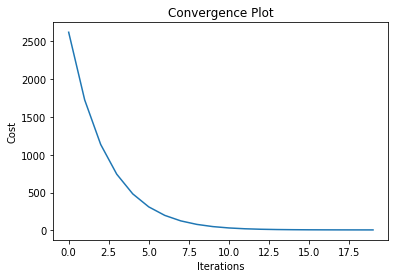

In [13]:
print(auc_score(vbpr, X_train))
print(auc_score(vbpr, X_test))
plt.plot(vbpr.history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()